In [1]:
import requests
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image

'''
NHL API: https://gitlab.com/dword4/nhlapi/-/tree/master

More info: 

inspirations:
https://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d
https://towardsdatascience.com/python-hockey-analytics-tutorial-b0883085938a#ee0a
https://github.com/rkipp1210/data-projects/tree/master/hockey-shot-blocking
'''

'\nNHL API: https://gitlab.com/dword4/nhlapi/-/tree/master\n\nMore info: \n\ninspirations:\nhttps://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d\nhttps://towardsdatascience.com/python-hockey-analytics-tutorial-b0883085938a#ee0a\nhttps://github.com/rkipp1210/data-projects/tree/master/hockey-shot-blocking\n'

In [2]:
teamdf = pd.read_csv("data/teams.csv", index_col = 0)
teamdf.head()

,id,name,link,abbreviation,teamName,locationName,firstYearOfPlay,shortName,officialSiteUrl,franchiseId,...,division.nameShort,division.link,division.abbreviation,conference.id,conference.name,conference.link,franchise.franchiseId,franchise.teamName,franchise.link,venue.id
0,1,New Jersey Devils,/api/v1/teams/1,NJD,Devils,New Jersey,1982,New Jersey,http://www.newjerseydevils.com/,23,...,Metro,/api/v1/divisions/18,M,6,Eastern,/api/v1/conferences/6,23,Devils,/api/v1/franchises/23,NaN
1,2,New York Islanders,/api/v1/teams/2,NYI,Islanders,New York,1972,NY Islanders,http://www.newyorkislanders.com/,22,...,Metro,/api/v1/divisions/18,M,6,Eastern,/api/v1/conferences/6,22,Islanders,/api/v1/franchises/22,NaN
2,3,New York Rangers,/api/v1/teams/3,NYR,Rangers,New York,1926,NY Rangers,http://www.newyorkrangers.com/,10,...,Metro,/api/v1/divisions/18,M,6,Eastern,/api/v1/conferences/6,10,Rangers,/api/v1/franchises/10,5054.0
3,4,Philadelphia Flyers,/api/v1/teams/4,PHI,Flyers,Philadelphia,1967,Philadelphia,http://www.philadelphiaflyers.com/,16,...,Metro,/api/v1/divisions/18,M,6,Eastern,/api/v1/conferences/6,16,Flyers,/api/v1/franchises/16,5096.0
4,5,Pittsburgh Penguins,/api/v1/teams/5,PIT,Penguins,Pittsburgh,1967,Pittsburgh,http://pittsburghpenguins.com/,17,...,Metro,/api/v1/divisions/18,M,6,Eastern,/api/v1/conferences/6,17,Penguins,/api/v1/franchises/17,5034.0


In [3]:
teamdf.loc[teamdf.name == "Vancouver Canucks", "id"].values[0]

23

In [4]:
seasons = "20182019"
r = requests.get("https://statsapi.web.nhl.com/api/v1/" + "schedule?season=" + seasons + "&gameType=R&site=en_nhl&teamId=" + '23')
data = r.json()
df = pd.DataFrame(data["dates"])
dates = df.date.tolist()
df.head()

,date,totalItems,totalEvents,totalGames,totalMatches,games,events,matches
0,2018-10-03,1,0,1,0,"[{'gamePk': 2018020003, 'link': '/api/v1/game/...",[],[]
1,2018-10-06,1,0,1,0,"[{'gamePk': 2018020028, 'link': '/api/v1/game/...",[],[]
2,2018-10-09,1,0,1,0,"[{'gamePk': 2018020037, 'link': '/api/v1/game/...",[],[]
3,2018-10-11,1,0,1,0,"[{'gamePk': 2018020053, 'link': '/api/v1/game/...",[],[]
4,2018-10-13,1,0,1,0,"[{'gamePk': 2018020064, 'link': '/api/v1/game/...",[],[]


In [5]:
gamedf = pd.DataFrame(df.games.tolist())
gamedf.columns= ['games']
gamedf.head()
gamedf.iloc[0,0]

{'gamePk': 2018020003,
 'link': '/api/v1/game/2018020003/feed/live',
 'gameType': 'R',
 'season': '20182019',
 'gameDate': '2018-10-04T02:00:00Z',
 'status': {'abstractGameState': 'Final',
  'codedGameState': '7',
  'detailedState': 'Final',
  'statusCode': '7',
  'startTimeTBD': False},
 'teams': {'away': {'leagueRecord': {'wins': 0,
    'losses': 1,
    'ot': 0,
    'type': 'league'},
   'score': 2,
   'team': {'id': 20, 'name': 'Calgary Flames', 'link': '/api/v1/teams/20'}},
  'home': {'leagueRecord': {'wins': 1, 'losses': 0, 'ot': 0, 'type': 'league'},
   'score': 5,
   'team': {'id': 23,
    'name': 'Vancouver Canucks',
    'link': '/api/v1/teams/23'}}},
 'venue': {'id': 5073, 'name': 'Rogers Arena', 'link': '/api/v1/venues/5073'},
 'content': {'link': '/api/v1/game/2018020003/content'}}

In [6]:
gamedf = pd.json_normalize(gamedf.games)
gamedf.columns

Index(['gamePk', 'link', 'gameType', 'season', 'gameDate',
       'status.abstractGameState', 'status.codedGameState',
       'status.detailedState', 'status.statusCode', 'status.startTimeTBD',
       'teams.away.leagueRecord.wins', 'teams.away.leagueRecord.losses',
       'teams.away.leagueRecord.ot', 'teams.away.leagueRecord.type',
       'teams.away.score', 'teams.away.team.id', 'teams.away.team.name',
       'teams.away.team.link', 'teams.home.leagueRecord.wins',
       'teams.home.leagueRecord.losses', 'teams.home.leagueRecord.ot',
       'teams.home.leagueRecord.type', 'teams.home.score',
       'teams.home.team.id', 'teams.home.team.name', 'teams.home.team.link',
       'venue.id', 'venue.name', 'venue.link', 'content.link'],
      dtype='object')

In [7]:
gamedf = gamedf.loc[:, ['gamePk', 'link', "teams.away.team.name", "teams.home.team.name", 'gameType','season', 'status.abstractGameState']]
gamedf = gamedf.rename(columns = {"teams.away.team.name": "away", "teams.home.team.name" : "home", "status.abstractGameState":"status"})
gamedf['date'] = dates
gamedf.head()


,gamePk,link,away,home,gameType,season,status,date
0,2018020003,/api/v1/game/2018020003/feed/live,Calgary Flames,Vancouver Canucks,R,20182019,Final,2018-10-03
1,2018020028,/api/v1/game/2018020028/feed/live,Vancouver Canucks,Calgary Flames,R,20182019,Final,2018-10-06
2,2018020037,/api/v1/game/2018020037/feed/live,Vancouver Canucks,Carolina Hurricanes,R,20182019,Final,2018-10-09
3,2018020053,/api/v1/game/2018020053/feed/live,Vancouver Canucks,Tampa Bay Lightning,R,20182019,Final,2018-10-11
4,2018020064,/api/v1/game/2018020064/feed/live,Vancouver Canucks,Florida Panthers,R,20182019,Final,2018-10-13


In [8]:
gamelinks = gamedf.link.tolist()



In [9]:
livedata = []

for gamelink in gamelinks:
    r = requests.get("https://statsapi.web.nhl.com" + gamelink)
    data = r.json()
    livedata.append(data)


In [10]:
'''
gamedata goes:
{
copyright
gamePk
link
metadata
gameData: {game, datetime, status, teams, players}
**liveData**: 
}

liveData goes: 
{
plays: {}
}'''



'\ngamedata goes:\n{\ncopyright\ngamePk\nlink\nmetadata\ngameData: {game, datetime, status, teams, players}\n**liveData**: \n}\n\nliveData goes: \n{\nplays: {}\n}'

In [11]:
# Initialise the player dictionary
full_name = 'Brock Boeser'
event_types = ['Shot','Goal']

player_data = {};
player_data['Shot'] = {};
player_data['Shot']['x'] = [];
player_data['Shot']['y'] = [];
player_data['Shot']['Type'] = []
player_data['Shot']['GamePk'] = []


player_data['Goal'] = {};
player_data['Goal']['x'] = [];
player_data['Goal']['y'] = [];
player_data['Goal']['Type'] = []
player_data['Goal']['GamePk'] = []


In [12]:
for data in livedata:
    if "liveData" not in data:
        continue
        
    # extract from playbyplay livedata
    plays = data['liveData']['plays']['allPlays']
    
    for play in plays:
        if "players" in play:
            for player in play["players"]:
                if player["player"]["fullName"] in [full_name] and player["playerType"] in ["Shooter", "Scorer"]:
                    event = play["result"]["event"]
                    #if play contains one of the events
                    
                    if event in event_types:
                        if play["about"]["periodType"] == "SHOOTOUT":
                            continue
                        if "x" in play["coordinates"]:
                            player_data[event]["x"].append(play["coordinates"]["x"])
                            player_data[event]["y"].append(play["coordinates"]["y"])
                            player_data[event]["Type"].append(play["result"]["secondaryType"])
                            player_data[event]["GamePk"].append(data["gamePk"])
                            
                                                             

In [13]:
# pd.set_option('display.max_rows', None)
gamelink = gamedf.loc[gamedf.date == "2019-02-14"]["link"].iloc[0]
r = requests.get("https://statsapi.web.nhl.com" + gamelink)
data = r.json()


In [14]:
# https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file
import json
with open('data/gamedata.json', 'w') as f:
    json.dump(data, f)

In [15]:
pd.DataFrame(player_data["Shot"])

,x,y,Type,GamePk
0,82.0,-21.0,Wrist Shot,2018020028
1,59.0,-20.0,Wrist Shot,2018020028
2,-64.0,14.0,Wrist Shot,2018020037
3,51.0,-19.0,Wrist Shot,2018020053
4,48.0,11.0,Slap Shot,2018020053
...,...,...,...,...
178,85.0,6.0,Wrist Shot,2018021249
179,48.0,-31.0,Wrist Shot,2018021249
180,-36.0,33.0,Wrist Shot,2018021249
181,-82.0,-7.0,Backhand,2018021258


In [16]:
# Get the total number of shots made by the player
player_total_shots = len(player_data['Shot']['x']) + len(player_data['Goal']['x'])
player_total_shots

209

In [17]:
player_data_normalized = player_data.copy()
for i, x in enumerate(player_data_normalized['Shot']['x']):
    if x < 0:
        player_data_normalized['Shot']['x'][i] = player_data_normalized['Shot']['x'][i] * -1
        player_data_normalized['Shot']['y'][i] = player_data_normalized['Shot']['y'][i] * -1
        
for i, x in enumerate(player_data_normalized['Goal']['x']):
    if x < 0:
        player_data_normalized['Goal']['x'][i] = player_data_normalized['Goal']['x'][i] * -1
        player_data_normalized['Goal']['y'][i] = player_data_normalized['Goal']['y'][i] * -1


In [18]:
# Find the players goal score percentage
player_goal_pct = len(player_data['Goal']['x'])/player_total_shots
player_goal_pct

0.12440191387559808

In [19]:
# To keep the aspect ration correct we use a square figure size
xbnds = np.array([-100.,100.0])
ybnds = np.array([-100,100])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
# We are going to bin in 30 unit increments.  It is fun to play with this!  
gridsize= 30;mincnt=0

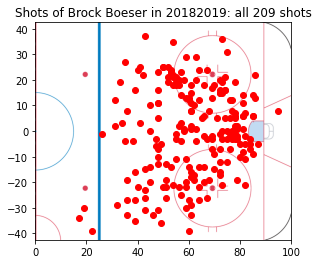

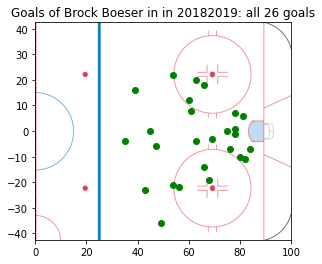

In [20]:
fig, ax = plt.subplots()
img = plt.imread("rink.png")
ax.imshow(img, extent = [0, 100, -42.5, 42.5])
plt.scatter(player_data['Shot']['x'], player_data['Shot']["y"], c = "red")
plt.scatter(player_data['Goal']['x'], player_data['Goal']["y"], c = "red")
plt.title(f"Shots of {full_name} in {seasons}: all {player_total_shots} shots")
plt.show()

fig, ax = plt.subplots()
img = plt.imread("rink.png")
ax.imshow(img, extent = [0, 100, -42.5, 42.5])
plt.scatter(player_data['Goal']['x'], player_data['Goal']["y"], c = "green")
plt.title(f"Goals of {full_name} in in {seasons}: all {len(player_data['Goal']['x'])} goals")
plt.show()


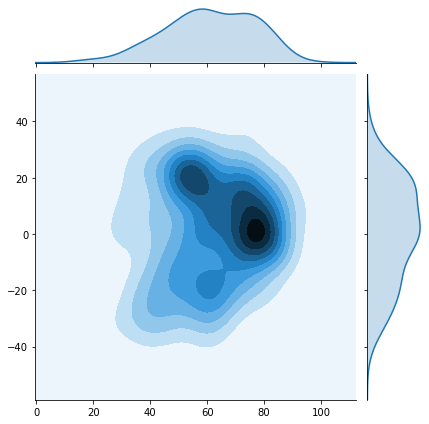

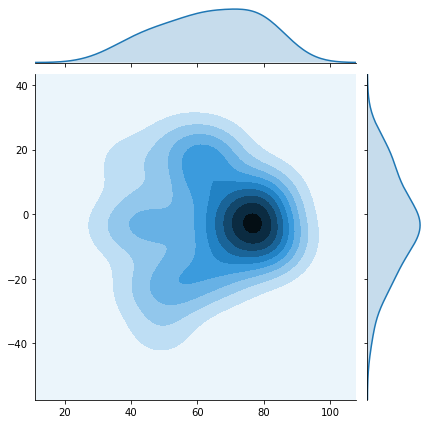

In [21]:
sns.jointplot(x="x", y="y", data=player_data_normalized['Shot'],kind="kde")
sns.jointplot(x="x", y="y", data=player_data_normalized['Goal'],kind="kde")
